# Introduction
We are trying to track physical displacement using both the accelerometer and gyroscope on a [BerryIMUv3](https://www.amazon.com/BerryIMUv2-10DOF-Accelerometer-Gyroscope-Magnetometer-Barometric/dp/B072MN8ZRC?psc=1). This notebook documents how we denoise the sensor's output and correct for some orientation bias.

In [36]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from IPython.display import display
import random

# Load data from filesystem
dfs = []
for i in range(10):
    df = pd.read_csv(f"data/test{i+1}.csv")
    df["zG"] = df["zG"] - 1 # Correct the Z acceleration
    dfs.append(df)

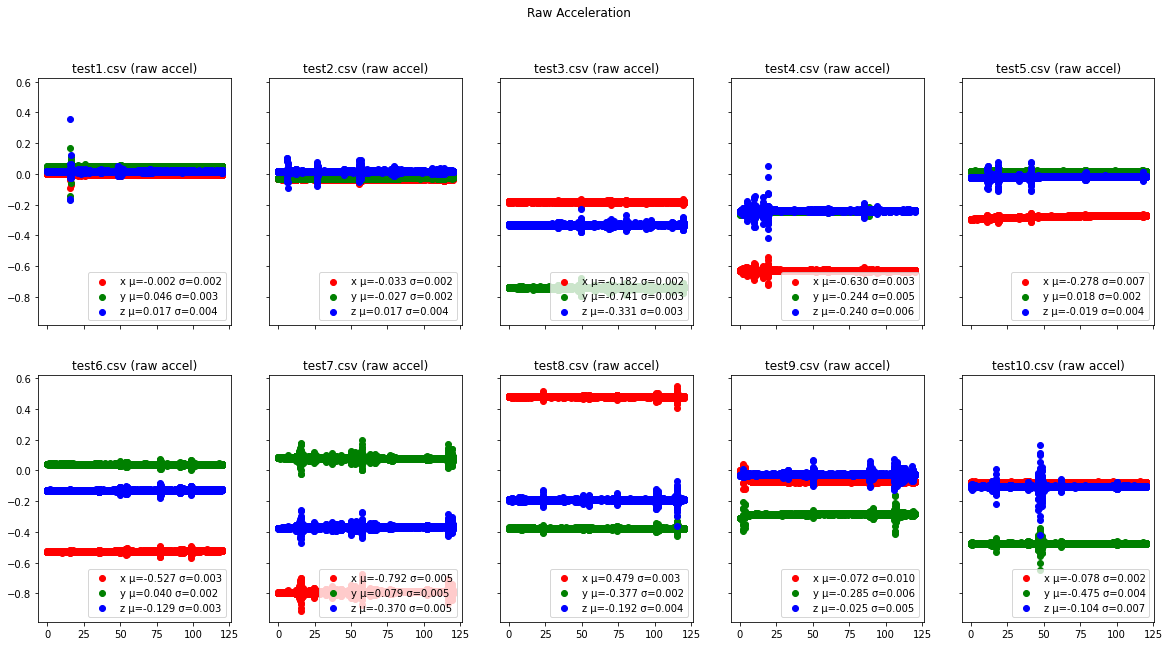

In [37]:
# Show the raw acceleration data
fig, axs = plt.subplots(2, 5, figsize=(20, 10), sharex=True, sharey=True)
fig.suptitle("Raw Acceleration")

for i in range(10):
    df = dfs[i]

    ax = axs[i // 5, i % 5]
    
    ax.scatter(df["time"], df["xG"], color="r", label=f"x μ={df['xG'].mean():.3f} σ={df['xG'].std():.3f}")
    ax.scatter(df["time"], df["yG"], color="g", label=f"y μ={df['yG'].mean():.3f} σ={df['yG'].std():.3f}")
    ax.scatter(df["time"], df["zG"], color="b", label=f"z μ={df['zG'].mean():.3f} σ={df['zG'].std():.3f}")

    ax.title.set_text(f"test{i+1}.csv (raw accel)")
    ax.legend(loc="lower right")

plt.show()

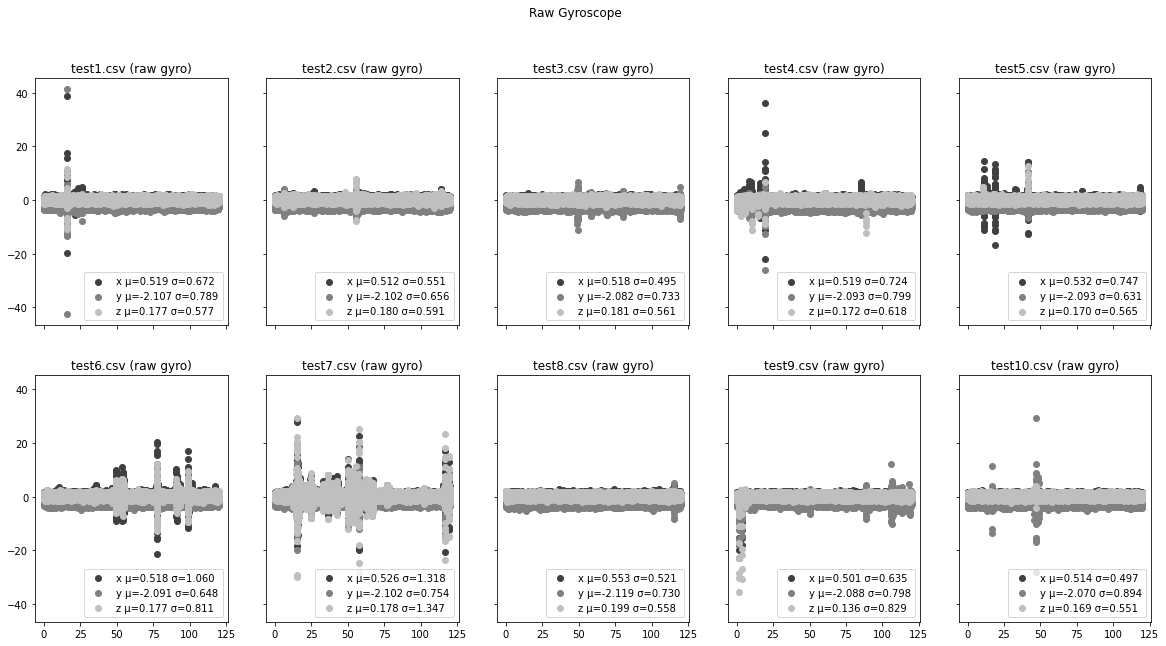

In [40]:
# Show the raw gyro data
fig, axs = plt.subplots(2, 5, figsize=(20, 10), sharex=True, sharey=True)
fig.suptitle("Raw Gyroscope")

for i in range(10):
    df = dfs[i]

    ax = axs[i // 5, i % 5]
    
    ax.scatter(df["time"], df["gyro_x"], color=".25", label=f"x μ={df['gyro_x'].mean():.3f} σ={df['gyro_x'].std():.3f}")
    ax.scatter(df["time"], df["gyro_y"], color=".50", label=f"y μ={df['gyro_y'].mean():.3f} σ={df['gyro_y'].std():.3f}")
    ax.scatter(df["time"], df["gyro_z"], color=".75", label=f"z μ={df['gyro_z'].mean():.3f} σ={df['gyro_z'].std():.3f}")

    ax.title.set_text(f"test{i+1}.csv (raw gyro)")
    ax.legend(loc="lower right")

plt.show()

# Simple Moving Average
A [SMA](https://en.wikipedia.org/wiki/Moving_average) is one of the easiest ways to denoise fuzzy data like this. The following code takes a random test run and denoises it using a SMA. Note that the bin size is arbitrary and has an inherent tradeoff. A larger bin size will reduce the noise, but will make the readings react less to quick changes. This tradeoff is important and we will likely need to tune it to get an optimal SMA for our accelerometer and use case. A key thing to notice here is that the standard deviation (σ) of the data drops significantly when we apply an SMA

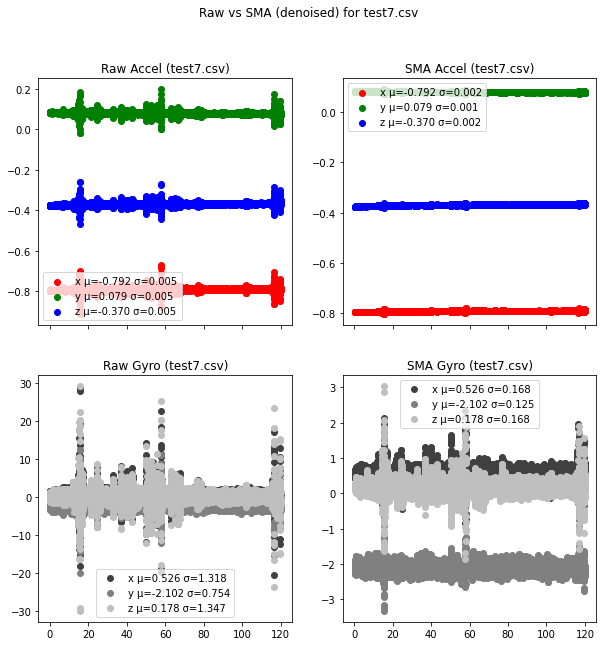

In [46]:
bin = 20 # arbitrary
i = random.randint(0, 9)

reg_df = dfs[i]
sma_df = dfs[i].copy()

sma_df["xG"] = reg_df["xG"].rolling(bin).mean()
sma_df["yG"] = reg_df["yG"].rolling(bin).mean()
sma_df["zG"] = reg_df["zG"].rolling(bin).mean()

sma_df["gyro_x"] = reg_df["gyro_x"].rolling(bin).mean()
sma_df["gyro_y"] = reg_df["gyro_y"].rolling(bin).mean()
sma_df["gyro_z"] = reg_df["gyro_z"].rolling(bin).mean()

fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharex=True)
fig.suptitle(f"Raw vs SMA (denoised) for test{i+1}.csv")

# Raw accelerometer
axs[0, 0].title.set_text(f"Raw Accel (test{i+1}.csv)")
axs[0, 0].scatter(reg_df["time"], reg_df["xG"], color="r", label=f"x μ={reg_df['xG'].mean():.3f} σ={reg_df['xG'].std():.3f}")
axs[0, 0].scatter(reg_df["time"], reg_df["yG"], color="g", label=f"y μ={reg_df['yG'].mean():.3f} σ={reg_df['yG'].std():.3f}")
axs[0, 0].scatter(reg_df["time"], reg_df["zG"], color="b", label=f"z μ={reg_df['zG'].mean():.3f} σ={reg_df['zG'].std():.3f}")
axs[0, 0].legend()

# SMA accelerometer
axs[0, 1].title.set_text(f"SMA Accel (test{i+1}.csv)")
axs[0, 1].scatter(sma_df["time"], sma_df["xG"], color="r", label=f"x μ={sma_df['xG'].mean():.3f} σ={sma_df['xG'].std():.3f}")
axs[0, 1].scatter(sma_df["time"], sma_df["yG"], color="g", label=f"y μ={sma_df['yG'].mean():.3f} σ={sma_df['yG'].std():.3f}")
axs[0, 1].scatter(sma_df["time"], sma_df["zG"], color="b", label=f"z μ={sma_df['zG'].mean():.3f} σ={sma_df['zG'].std():.3f}")
axs[0, 1].legend()


# Raw gyro
axs[1, 0].title.set_text(f"Raw Gyro (test{i+1}.csv)")
axs[1, 0].scatter(reg_df["time"], reg_df["gyro_x"], color=".25", label=f"x μ={reg_df['gyro_x'].mean():.3f} σ={reg_df['gyro_x'].std():.3f}")
axs[1, 0].scatter(reg_df["time"], reg_df["gyro_y"], color=".50", label=f"y μ={reg_df['gyro_y'].mean():.3f} σ={reg_df['gyro_y'].std():.3f}")
axs[1, 0].scatter(reg_df["time"], reg_df["gyro_z"], color=".75", label=f"z μ={reg_df['gyro_z'].mean():.3f} σ={reg_df['gyro_z'].std():.3f}")
axs[1, 0].legend()

# SMA gyro
axs[1, 1].title.set_text(f"SMA Gyro (test{i+1}.csv)")
axs[1, 1].scatter(sma_df["time"], sma_df["gyro_x"], color=".25", label=f"x μ={sma_df['gyro_x'].mean():.3f} σ={sma_df['gyro_x'].std():.3f}")
axs[1, 1].scatter(sma_df["time"], sma_df["gyro_y"], color=".50", label=f"y μ={sma_df['gyro_y'].mean():.3f} σ={sma_df['gyro_y'].std():.3f}")
axs[1, 1].scatter(sma_df["time"], sma_df["gyro_z"], color=".75", label=f"z μ={sma_df['gyro_z'].mean():.3f} σ={sma_df['gyro_z'].std():.3f}")
axs[1, 1].legend()

plt.show()